# Increasing the number of enemies

## 1.  Two Enemies

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


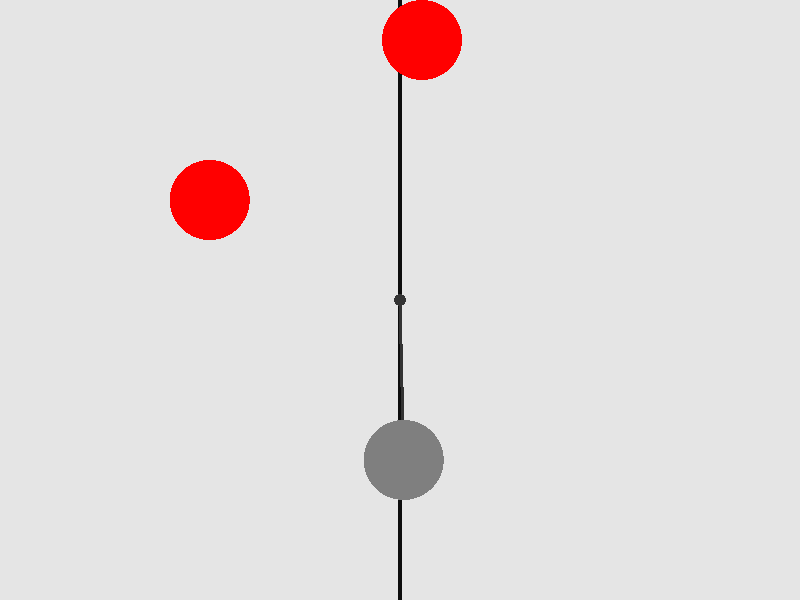

In [11]:
from IPython.core.display import clear_output
from torch.optim.lr_scheduler import StepLR
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import torch
from torch.nn import LeakyReLU, functional as F
from torch.optim import Adam

from framework import TrajectoryRewardsEvaluator, SeededGenerator
from pendulum import PendulumEnvironment, PendulumRenderer
from pendulum.heuristic import *
from shared_parameters import *
from utils import set_matplotlib_colors, MLP, sample_from, save, load, running_average

torch.set_printoptions(sci_mode=False)

time_scale = 5
max_trajectory_length = max_trajectory_length_1 // time_scale

env = PendulumEnvironment(*pendulum_env_args, enemy_y_1, time_scale=time_scale, step_reward=1.0, action_reward=-0.1,
                          death_reward=-100.0)
renderer = PendulumRenderer(bob_radius, connector_length, enemy_radius, enemy_y, enemy_y_1)

renderer.render(env.get_starting_state(), to_image=True)

We will use trajectory rewards oracle, as for now it's more straightforward and reliable

In [2]:
skills = [1.0, 0.5, 0.0]
weights = [0.5, 0.25, 0.25]
agents = [HeuristicPendulumActor(enemy_radius, bob_radius, connector_length, enemy_y, skill=skill) for skill in skills]
oracle = TrajectoryRewardsEvaluator(env, agents, weights, num_evaluations=10,
                                    max_trajectory_length=max_trajectory_length)

states = torch.vstack([env.get_starting_state() for _ in range(10)])
oracle.evaluate(states)

tensor([[0.8877],
        [0.9282],
        [0.9351],
        [0.7682],
        [0.1018],
        [0.9173],
        [0.8264],
        [0.8659],
        [0.8851],
        [0.9287]])

Now we can train NN evaluator. 2 inputs ($x_0$ and $x_1$).

Create a dataset and evaluate it (whole, directly - for simplicity)

In [3]:
# Dataset with just two numbers
embedding_dataset = torch.cartesian_prod(*[torch.linspace(enemy_x_min, enemy_x_max, 10) for _ in range(2)])

# Dataset with states (for evaluator)
states_dataset = torch.vstack([env.get_starting_state() for _ in range(embedding_dataset.shape[0])])
states_dataset.enemy_x = embedding_dataset
evaluations = oracle(states_dataset, verbose=True)


Evaluating 0/100...
Evaluating 10/100...
Evaluating 20/100...
Evaluating 30/100...
Evaluating 40/100...
Evaluating 50/100...
Evaluating 60/100...
Evaluating 70/100...
Evaluating 80/100...
Evaluating 90/100...
Done.


Create and train NN evaluator

In [4]:
evaluator = MLP(in_size=2, out_size=1, hidden=[8, 16, 16, 8], activation=LeakyReLU())
optim = Adam(evaluator.parameters(), lr=0.01)

# Training loop
i = 0
loss = float("inf")
while loss > 0.001 and i < 100000:
    sample_embeddings, indices = sample_from(embedding_dataset, size=15, indices=True)

    predicted = evaluator(sample_embeddings)
    actual = evaluations[indices]

    loss = F.mse_loss(predicted, actual)

    if i % 100 == 0:
        clear_output(wait=True)
        print(f"It. {i}. loss: {loss.item():.5f}")

    optim.zero_grad()
    loss.backward()
    optim.step()

    i += 1

clear_output(wait=True)
print(f"It. {i}. loss: {loss.item():.5f}. Done.")

save(evaluator, "./saved_data/5_multiple_enemies/evaluator.plt")

It. 7957. loss: 0.00092. Done.


Now we can train the generator

It.: 5102, difficulty_loss=0.05044 offsets_loss=0.76559


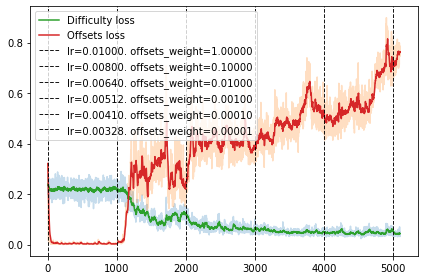

In [16]:
state = env.get_starting_state()
states = torch.stack([state.clone() for _ in range(100)])
enemy_xs = torch.linspace(enemy_x_min, enemy_x_max, states.shape[0]).unsqueeze(-1)
states.enemy_x = enemy_xs

bounds = torch.tensor([[enemy_x_min, enemy_x_max], [enemy_x_min, enemy_x_max]])
generator = SeededGenerator(bounds, hidden=[8, 16, 16, 8], activation=LeakyReLU(), optimizer_class=Adam, lr=0.01).cuda()
scheduler = StepLR(generator.optim, 1000, 0.8)

evaluator = load("./saved_data/5_multiple_enemies/evaluator.plt").cuda()

num_difficulties = 100
num_seeds = 100

# Our dataset of [difficulty, seed] inputs
difficulties = torch.linspace(0, 1, num_difficulties)
seeds = torch.linspace(enemy_x_min, enemy_x_max, num_seeds)
dataset = torch.cartesian_prod(difficulties, seeds, seeds).cuda()

# For rendering
# r_difficulties = torch.linspace(0, 1, 10)
# r_seeds = torch.linspace(enemy_x_min, enemy_x_max, 10)
# r_dataset = torch.cartesian_prod(r_difficulties, r_seeds)

iteration = 0
loss_evaluator = float("inf")

state = env.get_starting_state()

losses_difficulty = []
losses_offsets = []
iterations = []
lrs = [scheduler.get_last_lr()[0]]
weights = [generator.offsets_weight]
step = 1000
step_current = step

def iterate(verbose=False):
    global dataset, iteration, step_current

    # Sample from the dataset
    indices = torch.randperm(dataset.shape[0], device="cuda")[:100]
    sample = dataset[indices]

    # Generate levels
    generated_levels = generator(sample)

    d_out = evaluator(generated_levels)

    # Train the generator on the evaluated difficulty
    loss_difficulty, loss_offsets = generator.update(d_out)
    scheduler.step()

    iteration += 1

    if iteration > step_current:
        generator.offsets_weight *= 0.1

        lrs.append(scheduler.get_last_lr()[0])
        weights.append(generator.offsets_weight)
        step_current += step

    iterations.append(iteration)
    losses_difficulty.append(loss_difficulty.item())
    losses_offsets.append(loss_offsets.item())

    if verbose:
        clear_output(wait=True)
        print(f"It.: {iteration}, "
              f"difficulty_loss={loss_difficulty.item():.5f} "
              f"offsets_loss={loss_offsets.item():.5f}")
        #
        # generated_states = generator(r_dataset).detach()
        #
        # d_out = evaluator(generated_states).detach()
        #
        # collected = torch.hstack((r_dataset, generated_states, d_out))
        #
        # fix, ax = plt.subplots()
        #
        # for i in range(r_seeds.shape[0]):
        #     selected = collected[i::r_difficulties.shape[0], :]
        #     ds, xs = selected[:, 0], selected[:, 2]
        #     ax.plot(xs, ds)
        #
        # ax.plot(r_seeds, evaluator(r_seeds.unsqueeze(-1)).detach())
        #
        # plt.tight_layout()
        #
        # plt.show()

        _, ax = plt.subplots()
        ax.plot(iterations, losses_difficulty, alpha=0.25)
        ax.plot(iterations, losses_offsets, alpha=0.25)
        ax.plot(iterations, running_average(losses_difficulty, 0.9), label="Difficulty loss")
        ax.plot(iterations, running_average(losses_offsets, 0.9), label="Offsets loss")

        s = 0
        for lr, w in zip(lrs, weights):
            ax.axvline(x=s, c="black", linestyle="--", alpha=0.9, linewidth=1, label=f"lr={lr:.5f}. offsets_weight={w:.5f}")
            s += step

        ax.legend()
        plt.tight_layout()

        plt.show()

iterate()

try:
    for _ in range(100):
        for _ in range(50):
            iterate()
        iterate(True)
except KeyboardInterrupt:
    pass

iterate(True)

In [17]:
%matplotlib qt

iterate(True)

It.: 5103, difficulty_loss=0.03692 offsets_loss=0.72006


In [ ]:
try:
    for _ in range(100):
        for _ in range(50):
            iterate()
        iterate(True)
except KeyboardInterrupt:
    pass

iterate(True)

x0 = -0.50


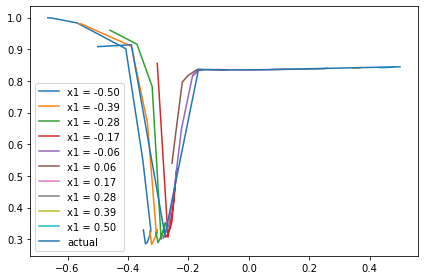

x0 = -0.39


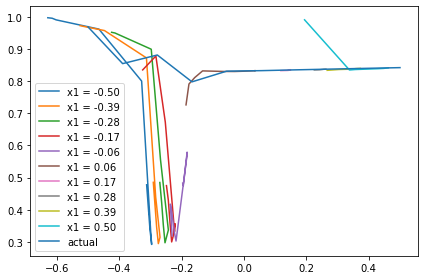

x0 = -0.28


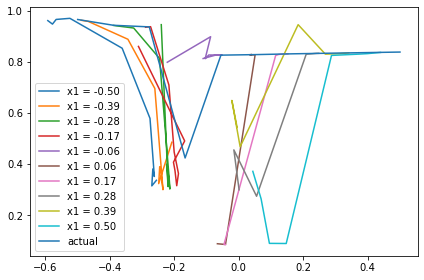

x0 = -0.17


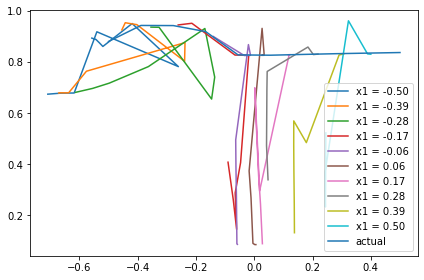

x0 = -0.06


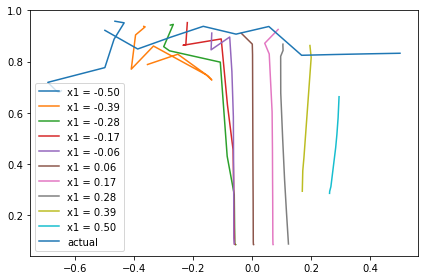

x0 = 0.06


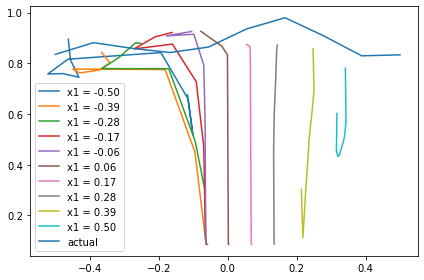

x0 = 0.17


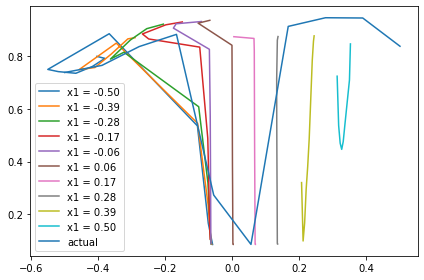

x0 = 0.28


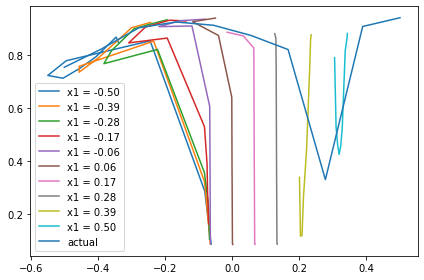

x0 = 0.39


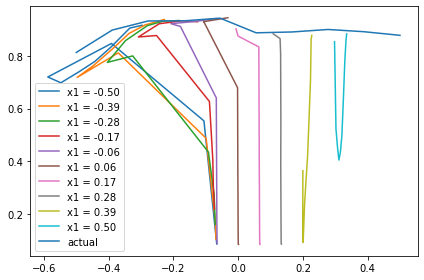

x0 = 0.50


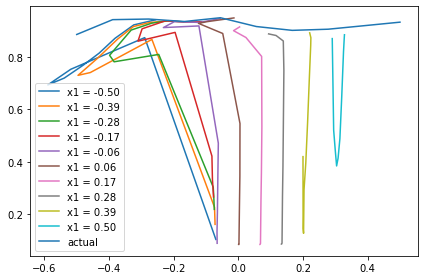

In [11]:
import matplotlib.pyplot as plt

generator.cpu()
evaluator.cpu()

enemy_range = torch.linspace(enemy_x_min, enemy_x_max, 10)

with torch.no_grad():
    r_dataset = torch.cartesian_prod(torch.linspace(0, 1, 10), *[enemy_range for _ in range(2)])

    generated = generator(r_dataset)
    difficulties = evaluator(generated)

    for i in range(10):
        print(f"x0 = {enemy_range[i]:.2f}")
        seed_0 = enemy_range[i]

        g = generated[i * 10: (i + 1) * 10]
        d = r_dataset[i * 10: (i + 1) * 10]

        for j in range(10):
            seed_1 = enemy_range[j]

            diff = difficulties[i * 10 + j::100, 0]
            g = generated[i * 10 + j::100, 1]

            plt.plot(g, diff)

        ein =torch.hstack((torch.full_like(enemy_range, enemy_range[i]).unsqueeze(-1), enemy_range.unsqueeze(-1)))
        plt.plot(enemy_range, evaluator(ein))

        plt.legend([*[f"x1 = {j:.2f}" for j in enemy_range], "actual"])
        plt.tight_layout()
        plt.show()

In [29]:
generator.cpu()
difficulties = torch.linspace(0, 1, 10)
seeds = torch.linspace(enemy_x_min, enemy_x_max, 10)
dataset = torch.cartesian_prod(difficulties, seeds, seeds).cuda()
embeddings = generator(dataset.cpu()).detach()
state = env.get_starting_state()
states = torch.stack([state.clone() for _ in embeddings])

states.enemy_x = embeddings

In [26]:
print(states.shape)

images = [renderer.render(s, width=300, height=300, to_image=True, resolution=1) for s in states]

torch.Size([1000, 5])


In [35]:
%matplotlib qt

for i_s1 in range(10):
    fig, axs = plt.subplots(10, 10)

    for i_s2 in range(10):
        for i_d in range(10):
            index = i_d * 100 + i_s1 * 10 + i_s2
            image = images[index]

            a = axs[i_d, i_s2]
            a.imshow(image)
            a.axis("off")

            difficulty, seed, _ = dataset[index]

            a.set_title(f"Difficulty={difficulty:.2f}\nSeed={seed:.2f}")

    plt.subplots_adjust(wspace=0.01, hspace=0.5)
    fig.set_size_inches(30, 30)
    plt.show()